# Latency Scatter

In [1]:
import quail
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import pearsonr
import numpy as np

%matplotlib inline
sns.set_context("notebook", font_scale=1.5)

# Import Data

In [2]:
# transcription 
auto_words = quail.load_egg('../data/auto_egg.egg')
man_words = quail.load_egg('../data/man_egg.egg')

In [3]:
# onsets
with open('automatic_onsets_NEWEST.p', 'rb') as file:
    auto_onsets = pickle.load(file)
    
with open('man_onsets_NEWEST.p', 'rb') as file:
    man_onsets = pickle.load(file)
    

# Define Function for Finding Matched Recalls

In [4]:
def get_matching_inds(x, y):
    def match_matrix(x, y):
        m = np.zeros([len(x) + 1, len(y) + 1])
        for i in np.arange(len(x)):
            for j in np.arange(len(y)):
                if x[i] == y[j]:
                    m[i+1, j+1] = m[i, j] + 1
                else:
                    m[i+1, j+1] = np.max([m[i, j+1], m[i+1, j]])
        return m
    
    def backtrack(m, x, y):
        i = len(x)
        j = len(y)
        
        longest_common_sequence = list()
        x_inds = list()
        y_inds = list()
        
        while (i >= 1) and (j >= 1):
            if m[i, j] == m[i, j-1]:
                j -= 1
            elif m[i, j] == m[i-1, j]:
                i -= 1                
            else:
                i -= 1
                j -= 1
                longest_common_sequence.insert(0, x[i])
                x_inds.insert(0, i)
                y_inds.insert(0, j)
        return longest_common_sequence, x_inds, y_inds
    
    return backtrack(match_matrix(x, y), x, y)

# Onset Data

## Replace Nones with Nans

In [5]:
from numpy import nan
man_words.rec.fillna(value=nan, inplace=True)
auto_words.rec.fillna(value=nan, inplace=True)
man_onsets.fillna(value=nan, inplace=True)
auto_onsets.fillna(value=nan, inplace=True)

# Obtain Onsets

In [6]:
x_onsets = []
y_onsets = []
list_corrs = []
sub_corrs = []

for sub in range(30):
    
    # subject-wise variables
    sub_lists_man = []
    sub_lists_auto = []
    
    for lst in range(8):

        # get man and auto words for this list
        man = list(man_words.rec.loc[sub].iloc[lst])
        auto = list(auto_words.rec.loc[sub].iloc[lst])
        
        # get the string and indices
        data = get_matching_inds(man, auto)
        
        # assign man and auto indices
        mo_ind = data[1]
        ao_ind = data[2]
        
        # generate list-wise correlations
        mo_list = [float(list(man_onsets.loc[sub].iloc[lst])[mo]) for mo in mo_ind]
        ao_list = [float(list(auto_onsets.loc[sub].iloc[lst])[ao]) for ao in ao_ind]
        list_corrs.append(pearsonr(mo_list, ao_list))
        
        # pull corr values out of tuple
        list_corrs_only = [x[0] for x in list_corrs]
        
        # generat subject-wise correlations
        sub_lists_man.append(mo_list)
        sub_lists_auto.append(ao_list)
        
        # get individual onset vals for all words, all subs, all lists 
        for mo,ao in zip(mo_ind, ao_ind):
            
            x_onsets.append(float(list(man_onsets.loc[sub].iloc[lst])[mo])*.001)
            y_onsets.append(float(list(auto_onsets.loc[sub].iloc[lst])[ao]))
            
    flat_man_lists = [item for sublist in sub_lists_man for item in sublist]
    flat_auto_lists = [item for sublist in sub_lists_auto for item in sublist]
    sub_corrs.append(pearsonr(flat_man_lists, flat_auto_lists))
        
    # pull corr values out of tuple
    sub_corrs_only = [x[0] for x in sub_corrs]

# Onset Correlation - By List

<a list of 99 Patch objects>

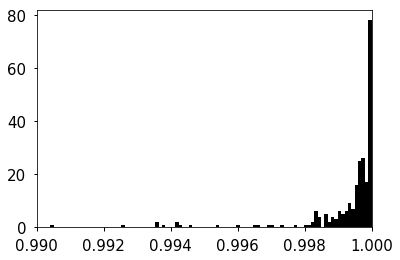

In [7]:
plt.xlim(.990, 1)

plt.hist(list_corrs_only, color='black', range=[.90, 1.00], bins=list(np.linspace(.99,1.00,100)))[2]


# Onset Correlation - By Word

<a list of 99 Patch objects>

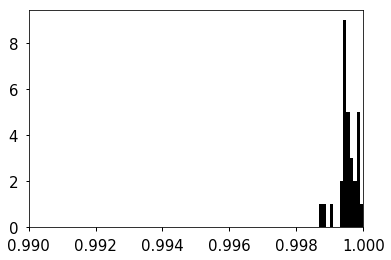

In [8]:
plt.xlim(.990, 1)
g = np.linspace(.99,1.00,100)

plt.hist(sub_corrs_only, color='black', range=[.90, 1.00], bins=list(g))[2]

(0.9995090337164165, 0.0)


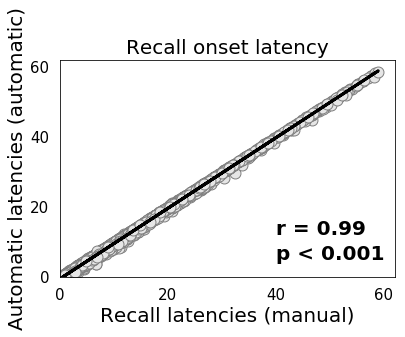

In [9]:
fig = plt.figure(2)
ax = fig.add_subplot(111)#, axisbg='white')
ax.scatter(x_onsets, y_onsets, facecolor='.9', linewidth=1, color='gray', s=120)#, linewidth=2.0)
plt.grid(False)

plt.axis([0, 62, 0, 62])
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.xlabel('Recall latencies (manual)', fontsize=20)
plt.ylabel('Automatic latencies (automatic)', fontsize=20)

reg_line = np.polyfit(x_onsets, y_onsets, 1)
plt.plot(x_onsets, np.poly1d(reg_line)(x_onsets), color='black', linewidth=3.0)

from scipy.stats import pearsonr
r = pearsonr(x_onsets, y_onsets)

plt.title('Recall onset latency', fontsize=20)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
plt.text(40, 12, 'r = ' + str(0.99), fontsize=20, fontweight='bold')
plt.text(40, 5, 'p < ' + str(0.001), fontsize=20, fontweight='bold')

print r